### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import keras

plt.style.use('ggplot')

Using TensorFlow backend.


### Main Function to create Data Frame

In [2]:
# Initial data preparation

def add_derived_columns(df):
    df_ext = df.copy()
    df_ext['jid'] = df_ext['uid'].map(str) + '_' + df_ext['conversion_id'].map(str)
    
    min_max_scaler = MinMaxScaler()
    for cname in ('timestamp', 'time_since_last_click'):
        x = df_ext[cname].values.reshape(-1, 1) 
        df_ext[cname + '_norm'] = min_max_scaler.fit_transform(x)
    
    return df_ext

def filter_journeys_by_length(df, min_touchpoints):
    if min_touchpoints <= 1:
        return df
    else:
        grouped = df.groupby(['jid'])['uid'].count().reset_index(name="count")
        return df[df['jid'].isin( grouped[grouped['count'] >= min_touchpoints]['jid'].values )]

def sample_campaigns(df, n_campaigns):    
    campaigns = np.random.choice( df['campaign'].unique(), n_campaigns, replace = False )
    return df[ df['campaign'].isin(campaigns) ]

def balance_conversions(df):
    df_minority = df[df.conversion == 1]
    df_majority = df[df.conversion == 0]
    
    df_majority_jids = np.array_split(df_majority['jid'].unique(), 100 * df_majority.shape[0]/df_minority.shape[0] )

    df_majority_sampled = pd.DataFrame(data=None, columns=df.columns)
    for jid_chunk in df_majority_jids:
        df_majority_sampled = pd.concat([df_majority_sampled, df_majority[df_majority.jid.isin(jid_chunk)]])
        if df_majority_sampled.shape[0] > df_minority.shape[0]:
            break
    
    return pd.concat([df_majority_sampled, df_minority]).sample(frac=1).reset_index(drop=True)

def map_one_hot(df, column_names, result_column_name):
    mapper = {} 
    for i, col_name in enumerate(column_names):
        for val in df[col_name].unique():
            mapper[str(val) + str(i)] = len(mapper)
         
    df_ext = df.copy()
    
    def one_hot(values):
        v = np.zeros( len(mapper) )
        for i, val in enumerate(values): 
            v[ mapper[str(val) + str(i)] ] = 1
        return v    
    
    df_ext[result_column_name] = df_ext[column_names].values.tolist()
    df_ext[result_column_name] = df_ext[result_column_name].map(one_hot)
    
    return df_ext
    
data_file = '/content/drive/My Drive/ADM_Asst3/criteo_attribution_dataset.tsv.gz'
df0 = pd.read_csv(data_file, sep='\t', compression='gzip')

n_campaigns = 400

df1 = add_derived_columns(df0)
df2 = sample_campaigns(df1, n_campaigns)
df3 = filter_journeys_by_length(df2, 2)
df4 = balance_conversions(df3)
df5 = map_one_hot(df4, ['cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat8'], 'cats')
df6 = map_one_hot(df5, ['campaign'], 'campaigns').sort_values(by=['timestamp_norm'])

print(df6.shape[0])
print([df6[df6.conversion == 0].shape[0], df6[df6.conversion == 1].shape[0]])

633450
[316893, 316557]


### First Touch Attribute

This model gives full sales credit to the first marketing touchpoint interacted with before conversion.

In [0]:
def first_touch_attribution(df):
    
    def count_by_campaign(df):
        counters = np.zeros(n_campaigns)
        for campaign_one_hot in df['campaigns'].values:
            campaign_id = np.argmax(campaign_one_hot)
            counters[campaign_id] = counters[campaign_id] + 1
        return counters
        
    campaign_impressions = count_by_campaign(df)
    
    df_converted = df[df['conversion'] == 1]
    idx = df_converted.groupby(['uid'])['timestamp_norm'].transform(min) == df_converted['timestamp_norm']
    campaign_conversions = count_by_campaign(df_converted[idx])
        
    return campaign_conversions / campaign_impressions
    
fta = first_touch_attribution(df6)

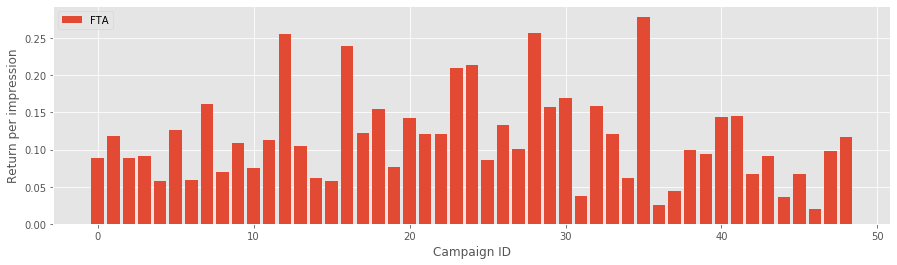

In [4]:
# Visualization of the attribution scores

campaign_idx = range(1,50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar( range(len(fta[campaign_idx])), fta[campaign_idx], label='FTA' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

### Linear Attribute


This gives each touchpoint across the buyer journey the same amount of credit toward driving a sale.

In [0]:
id_count = df6.groupby(['uid'])['campaign'].count()

In [0]:
df_id_count = pd.DataFrame(id_count.reset_index())

In [7]:
df_id_count.columns

Index(['uid', 'campaign'], dtype='object')

In [0]:
df_id_count = df_id_count.rename(columns={"campaign":"campaign_count"})

In [9]:
df_id_count.head()

,uid,campaign_count
0,601,3
1,656,3
2,889,9
3,999,3
4,1827,2


In [0]:
df_conv_user = df6[df6['conversion'] ==1]

In [0]:
df_conv_user = df_conv_user.sort_values('uid')

In [12]:
df_conv_user.shape[0]

316557

In [0]:
df_merge = df_conv_user.merge(df_id_count, on = ['uid'], how = 'left')

In [14]:
df_merge

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count
0,554012,656,27777499,1,718877,26044415,0,1,2,3,0.000168,0.095338,79309,27093701,9312274,21372185,29196072,11409686,3808271,20246687,29196072,29520629,656_26044415,0.207402,0.030598,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
1,474703,656,27777499,1,718877,26044415,0,1,1,3,0.000314,0.095220,429000,27093701,9312274,21372185,30054645,11409686,5824238,27512348,29196072,21091111,656_26044415,0.177712,0.165510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
2,45703,656,27777499,1,718877,26044415,0,1,0,3,0.000334,0.075868,202860,27093701,9312274,21372185,23549932,11409686,32440041,27277949,29196072,21091108,656_26044415,0.017110,0.078264,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,1617199,999,5061834,1,4103933,14996161,0,1,0,4,0.001932,0.287987,-1,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
4,2143779,999,5061834,1,4103933,14996161,0,1,2,4,0.001035,0.310221,8415,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316552,24327,32458202,2576437,1,625696,26332147,0,1,12,17,0.000223,0.098605,131793,30763035,5642940,30345721,29196072,32440044,1973606,23932668,26597096,29520626,32458202_26332147,0.009107,0.050846,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
316553,497632,32458202,2576437,1,625696,26332147,0,1,16,17,0.001277,0.114174,42851,30763035,5642940,30345721,29196072,32440044,1973606,3698652,29196072,9491354,32458202_26332147,0.186295,0.016532,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
316554,454781,32458202,2576437,1,625696,26332147,0,1,15,17,0.000628,0.102350,388847,30763035,5642940,30345721,29196072,32440044,1973606,3698652,20754144,21091111,32458202_26332147,0.170254,0.150018,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5
316555,1078474,32458592,8287704,1,1240667,16312783,1,1,0,2,0.000022,0.149125,-1,25259032,9312274,28538391,29196072,11409686,1973606,9312274,20754144,29196072,32458592_16312783,0.403742,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [15]:
df_merge.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'campaign_count'],
      dtype='object')

In [0]:
camp_prob = []

In [0]:
for index , row in df_merge.iterrows():
  camp_prob.append(1/row['campaign_count'])

df_merge['campaign_probability'] =   camp_prob

In [18]:
df_merge

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count,campaign_probability
0,554012,656,27777499,1,718877,26044415,0,1,2,3,0.000168,0.095338,79309,27093701,9312274,21372185,29196072,11409686,3808271,20246687,29196072,29520629,656_26044415,0.207402,0.030598,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
1,474703,656,27777499,1,718877,26044415,0,1,1,3,0.000314,0.095220,429000,27093701,9312274,21372185,30054645,11409686,5824238,27512348,29196072,21091111,656_26044415,0.177712,0.165510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
2,45703,656,27777499,1,718877,26044415,0,1,0,3,0.000334,0.075868,202860,27093701,9312274,21372185,23549932,11409686,32440041,27277949,29196072,21091108,656_26044415,0.017110,0.078264,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
3,1617199,999,5061834,1,4103933,14996161,0,1,0,4,0.001932,0.287987,-1,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
4,2143779,999,5061834,1,4103933,14996161,0,1,2,4,0.001035,0.310221,8415,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316552,24327,32458202,2576437,1,625696,26332147,0,1,12,17,0.000223,0.098605,131793,30763035,5642940,30345721,29196072,32440044,1973606,23932668,26597096,29520626,32458202_26332147,0.009107,0.050846,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.200000
316553,497632,32458202,2576437,1,625696,26332147,0,1,16,17,0.001277,0.114174,42851,30763035,5642940,30345721,29196072,32440044,1973606,3698652,29196072,9491354,32458202_26332147,0.186295,0.016532,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.200000
316554,454781,32458202,2576437,1,625696,26332147,0,1,15,17,0.000628,0.102350,388847,30763035,5642940,30345721,29196072,32440044,1973606,3698652,20754144,21091111,32458202_26332147,0.170254,0.150018,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5,0.200000
316555,1078474,32458592,8287704,1,1240667,16312783,1,1,0,2,0.000022,0.149125,-1,25259032,9312274,28538391,29196072,11409686,1973606,9312274,20754144,29196072,32458592_16312783,0.403742,0.000000,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,0.500000


In [19]:
df_merge.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'campaign_count',
       'campaign_probability'],
      dtype='object')

In [0]:
df_linear = df_merge.groupby('campaign')['campaign_probability'].sum()

In [0]:
df_linear

NameError: ignored

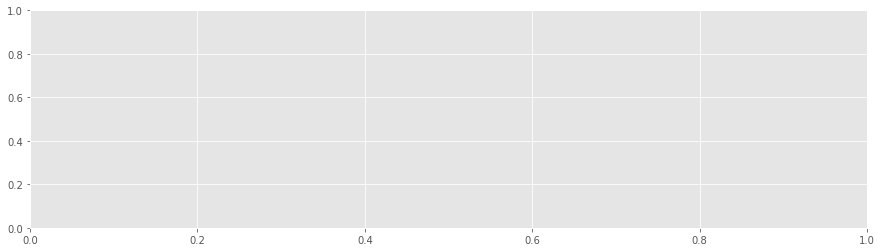

In [21]:
# Visualization of the attribution scores

campaign_idx = range(1,50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(camp_df['campaign'])), camp_df['campaign_wt'], label='Linear' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

### U shaped Model

U-shaped Model: This model attributes 40% each to the first touchpoint and lead conversion touchpoint. The other 20% is divided between the additional touchpoints encountered in between.

In [23]:
df_conv_user.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns'],
      dtype='object')

Get the minimum timestamp and maximum timestamp of campaign for each user

In [0]:
time_min = df_conv_user.groupby(['uid'])['campaign','timestamp_norm'].min()
time_max = df_conv_user.groupby(['uid'])['campaign','timestamp_norm'].max()


In [25]:
time_min.head()

,campaign,timestamp_norm
uid,,
656,27777499,0.017110
999,5061834,0.605421
1827,604244,0.187057
1900,29531983,0.382787
2316,23852329,0.017645


convert to Dataframe

In [0]:
df_min_time = pd.DataFrame(time_min)
df_max_time = pd.DataFrame(time_max)

In [0]:
df_min_time = df_min_time.reset_index()
df_max_time = df_max_time.reset_index()

In [28]:
df_min_time.head()

,uid,campaign,timestamp_norm
0,656,27777499,0.017110
1,999,5061834,0.605421
2,1827,604244,0.187057
3,1900,29531983,0.382787
4,2316,23852329,0.017645


Rename columns to include minimum & maximum timestamp in dataframe

In [0]:
df_min_time
df_min_time = df_min_time.rename(columns={"timestamp_norm":"min_timestamp"})

In [0]:
df_max_time.head()
df_max_time = df_max_time.rename(columns={"timestamp_norm":"max_timestamp"})

In [31]:
df_merge.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'campaign_count',
       'campaign_probability'],
      dtype='object')

In [32]:
df_max_time.columns

Index(['uid', 'campaign', 'max_timestamp'], dtype='object')

In [33]:
df_min_time.columns

Index(['uid', 'campaign', 'min_timestamp'], dtype='object')

Merge the max and min timestamp in dataframe

In [0]:
df_merge_time_max = pd.merge(df_merge,df_max_time,  how = 'inner', on =(['uid','campaign']),)

df_merge_time_min = pd.merge(df_merge_time_max,df_min_time,  how = 'inner', on =(['uid','campaign']),)


In [35]:
df_merge_time_max.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count,campaign_probability,max_timestamp
0,554012,656,27777499,1,718877,26044415,0,1,2,3,0.000168,0.095338,79309,27093701,9312274,21372185,29196072,11409686,3808271,20246687,29196072,29520629,656_26044415,0.207402,0.030598,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.207402
1,474703,656,27777499,1,718877,26044415,0,1,1,3,0.000314,0.095220,429000,27093701,9312274,21372185,30054645,11409686,5824238,27512348,29196072,21091111,656_26044415,0.177712,0.165510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.207402
2,45703,656,27777499,1,718877,26044415,0,1,0,3,0.000334,0.075868,202860,27093701,9312274,21372185,23549932,11409686,32440041,27277949,29196072,21091108,656_26044415,0.017110,0.078264,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.207402
3,1617199,999,5061834,1,4103933,14996161,0,1,0,4,0.001932,0.287987,-1,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.802553
4,2143779,999,5061834,1,4103933,14996161,0,1,2,4,0.001035,0.310221,8415,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.802553


In [36]:
df_merge_time_min.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count,campaign_probability,max_timestamp,min_timestamp
0,554012,656,27777499,1,718877,26044415,0,1,2,3,0.000168,0.095338,79309,27093701,9312274,21372185,29196072,11409686,3808271,20246687,29196072,29520629,656_26044415,0.207402,0.030598,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.207402,0.017110
1,474703,656,27777499,1,718877,26044415,0,1,1,3,0.000314,0.095220,429000,27093701,9312274,21372185,30054645,11409686,5824238,27512348,29196072,21091111,656_26044415,0.177712,0.165510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.207402,0.017110
2,45703,656,27777499,1,718877,26044415,0,1,0,3,0.000334,0.075868,202860,27093701,9312274,21372185,23549932,11409686,32440041,27277949,29196072,21091108,656_26044415,0.017110,0.078264,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.207402,0.017110
3,1617199,999,5061834,1,4103933,14996161,0,1,0,4,0.001932,0.287987,-1,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.802553,0.605421
4,2143779,999,5061834,1,4103933,14996161,0,1,2,4,0.001035,0.310221,8415,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.802553,0.605421


In [0]:
df_u_shape = df_merge_time_min

In [38]:
df_u_shape.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count,campaign_probability,max_timestamp,min_timestamp
0,554012,656,27777499,1,718877,26044415,0,1,2,3,0.000168,0.095338,79309,27093701,9312274,21372185,29196072,11409686,3808271,20246687,29196072,29520629,656_26044415,0.207402,0.030598,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.207402,0.017110
1,474703,656,27777499,1,718877,26044415,0,1,1,3,0.000314,0.095220,429000,27093701,9312274,21372185,30054645,11409686,5824238,27512348,29196072,21091111,656_26044415,0.177712,0.165510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.207402,0.017110
2,45703,656,27777499,1,718877,26044415,0,1,0,3,0.000334,0.075868,202860,27093701,9312274,21372185,23549932,11409686,32440041,27277949,29196072,21091108,656_26044415,0.017110,0.078264,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.207402,0.017110
3,1617199,999,5061834,1,4103933,14996161,0,1,0,4,0.001932,0.287987,-1,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.802553,0.605421
4,2143779,999,5061834,1,4103933,14996161,0,1,2,4,0.001035,0.310221,8415,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.333333,0.802553,0.605421


In [0]:
df_u_shape = df_u_shape.drop(columns=['campaign_probability'])

In [40]:
df_u_shape.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'campaign_count',
       'max_timestamp', 'min_timestamp'],
      dtype='object')

Check if timestamp is equal to minimum timestamp then assign 0.4 wt to campaign
if timestamp is equal to max timestamp then assign 0.4 wt to campaign
if campaign count of  user is equal to 1 then assign  1 wt to campaign
if campaign count of  user is equal to 2 then assign  0.5 wt to the campaign
if any of the condition doesnt meet , assign a random number between 0 to 0.2

**Summary**     
1 campaign --> 1 weigth                  
2 --> 0.5 wts to each                           
2 --> 1st campaign & last campaign (based on min and max timestamp) - 0.4 wts to each                    
remaining campaigns if > 2 --> random number between 0 - 0.2


In [0]:
df_u_shape['u_prob'] = np.where(df_u_shape['timestamp_norm']==df_u_shape['max_timestamp'], 
                                           '0.4', 
                                           np.where(df_u_shape['timestamp_norm']==df_u_shape['min_timestamp'], 
                                           '0.4', 
                                           np.random.uniform(0, 0.2, len(df_u_shape))))
                                

df_u_shape.loc[df_u_shape.campaign_count == 1, 'u_prob'] = 1

df_u_shape.loc[df_u_shape.campaign_count == 2, 'u_prob'] = 0.5

In [42]:
df_u_shape['u_prob'].value_counts()

0.4                     76898
0.5                     66642
0.14035800164658738         1
0.18203138162406732         1
0.039289835273293244        1
                        ...  
0.19900013770798508         1
0.05999340521039831         1
0.06751787539820686         1
0.08464804932879975         1
0.12717216674167664         1
Name: u_prob, Length: 163639, dtype: int64

In [0]:
u_shape_camp_count=df_u_shape['campaign'].value_counts()
u_shape_camp_count = pd.DataFrame(u_shape_camp_count.reset_index())

In [0]:
u_shape_camp_count.rename(columns={'index':'campaign',
                          'campaign':'campaign_count',}, inplace=True)

In [0]:
df_u_shape = df_u_shape.astype({"u_prob": float})
U_prob_sum = df_u_shape.groupby('campaign')['u_prob'].sum()

In [0]:
# U_prob_sum

In [0]:
U_prob_sum = pd.DataFrame(U_prob_sum)
U_prob_sum = U_prob_sum.reset_index()

In [0]:
u_shape_final = U_prob_sum.merge(u_shape_camp_count, on = ['campaign'], how = 'left')

In [0]:
u_shape_final['campaign_wt']  = u_shape_final['u_prob'] /u_shape_final['campaign_count']

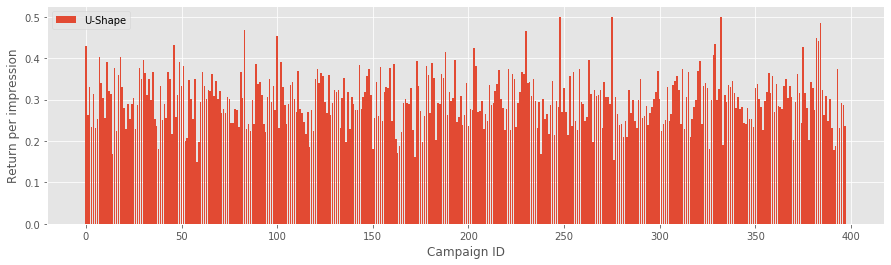

In [77]:
campaign_idx = range(1,50)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(u_shape_final['campaign'])), u_shape_final['campaign_wt'], label='U-Shape' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()

### Time Decay

This model gives more credit to the touchpoints a consumer interacts with closer to the conversion.60% would go to the last campaign , remianing 40% will be divided into other campaigns.

In [0]:
df_time_decay = df_merge_time_min

In [0]:
df_time_decay = df_time_decay.drop(columns=['campaign_probability'])

In [80]:
df_time_decay.columns

Index(['timestamp', 'uid', 'campaign', 'conversion', 'conversion_timestamp',
       'conversion_id', 'attribution', 'click', 'click_pos', 'click_nb',
       'cost', 'cpo', 'time_since_last_click', 'cat1', 'cat2', 'cat3', 'cat4',
       'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'jid', 'timestamp_norm',
       'time_since_last_click_norm', 'cats', 'campaigns', 'campaign_count',
       'max_timestamp', 'min_timestamp'],
      dtype='object')

if timestamp is equal to max timestamp then assign 0.6 wt to campaign
if campaign count of  user is equal to 1 then assign  1 wt to campaign
if campaign count of  user is equal to 2 then assign  0.4 wt to the 1st campaign and 0.6 to last campaign
if any of the condition doesnt meet , assign a random number between 0 to 0.4




In [0]:
df_time_decay['time_decay_prob'] = np.where(df_time_decay['timestamp_norm']==df_time_decay['max_timestamp'], 
                                           0.6,
                                            np.where(df_time_decay['campaign_count'] == 2 ,
                                                     0.4,
                                                     np.random.uniform(0, 0.4, len(df_time_decay))))

In [82]:
df_time_decay.shape[0]

307177

In [83]:
df_time_decay.head()

,timestamp,uid,campaign,conversion,conversion_timestamp,conversion_id,attribution,click,click_pos,click_nb,cost,cpo,time_since_last_click,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,jid,timestamp_norm,time_since_last_click_norm,cats,campaigns,campaign_count,max_timestamp,min_timestamp,time_decay_prob
0,554012,656,27777499,1,718877,26044415,0,1,2,3,0.000168,0.095338,79309,27093701,9312274,21372185,29196072,11409686,3808271,20246687,29196072,29520629,656_26044415,0.207402,0.030598,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.207402,0.017110,0.600000
1,474703,656,27777499,1,718877,26044415,0,1,1,3,0.000314,0.095220,429000,27093701,9312274,21372185,30054645,11409686,5824238,27512348,29196072,21091111,656_26044415,0.177712,0.165510,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.207402,0.017110,0.073484
2,45703,656,27777499,1,718877,26044415,0,1,0,3,0.000334,0.075868,202860,27093701,9312274,21372185,23549932,11409686,32440041,27277949,29196072,21091108,656_26044415,0.017110,0.078264,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.207402,0.017110,0.297302
3,1617199,999,5061834,1,4103933,14996161,0,1,0,4,0.001932,0.287987,-1,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,29196072,999_14996161,0.605421,0.000000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.802553,0.605421,0.270284
4,2143779,999,5061834,1,4103933,14996161,0,1,2,4,0.001035,0.310221,8415,30763035,9312274,28944165,29196072,26611392,29196072,5642940,29196072,15351056,999_14996161,0.802553,0.003247,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,0.802553,0.605421,0.600000


In [0]:
time_decay_count=df_time_decay['campaign'].value_counts()
time_decay_count = pd.DataFrame(time_decay_count.reset_index())
time_decay_count.rename(columns={'index':'campaign',
                          'campaign':'campaign_count',}, inplace=True)
time_decay_prob_sum = df_time_decay.groupby('campaign')['time_decay_prob'].sum()
time_decay_prob_sum = pd.DataFrame(time_decay_prob_sum)
time_decay_prob_sum = time_decay_prob_sum.reset_index()
time_decay_final = time_decay_prob_sum.merge(time_decay_count, on = ['campaign'], how = 'left')

In [0]:
time_decay_final['campaign_wt']  = time_decay_final['time_decay_prob'] /time_decay_final['campaign_count']

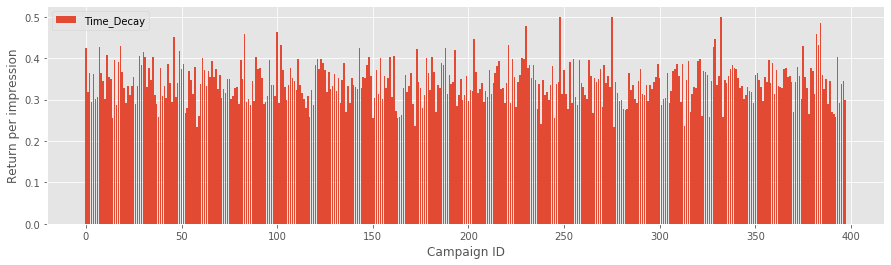

In [95]:
campaign_idx = range(1,20)

fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(111)
plt.bar(range(len(time_decay_final['campaign'])), time_decay_final['campaign_wt'], label='Time_Decay' )
plt.xlabel('Campaign ID')
plt.ylabel('Return per impression')
plt.legend(loc='upper left')
plt.show()